In [31]:
#Import corpora, clean data, train SVM model, and create science sentiment function

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from datetime import datetime

#Loading Dataframes
pro_sci = pd.read_csv('pro_science.csv',sep=',')
anti_sci = pd.read_csv('anti_science.csv')

#Renaming and Cleaning Dataframes
pro_sci = pro_sci.drop(columns='Unnamed: 0')
pro_sci.rename(columns= {'0':'Tweet'}, inplace=True)
#adds label 0 for pro-science Tweets
pro_sci['label'] = 1

anti_sci = anti_sci.drop(columns='Unnamed: 0')
anti_sci.rename(columns= {'0':'Tweet'}, inplace=True)
#adds label 0 for anti-science Tweets
anti_sci['label'] = 0

corpus = pro_sci.append(anti_sci, ignore_index=True)

#Text processing in corpus dataframe
#Lowercase
corpus['Tweet'] = [entry.lower() for entry in corpus['Tweet']]
#Tokenizing
corpus['Tweet']= [word_tokenize(entry) for entry in corpus['Tweet']]
#Tags for Word Lemmatization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(corpus['Tweet']):
    final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # Provides tags for nouns, verbs, adjectives
    for word, tag in pos_tag(entry):
        # Check for stopwords
        if word not in stopwords.words('english') and word.isalpha():
            word_final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            final_words.append(word_final)
    # Stores final processed words for each Tweet in column "text_final"
    corpus.loc[index,'text_final'] = str(final_words)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus['text_final'],corpus['label'],test_size=0.2)
Tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
Tfidf_vect.fit(corpus['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#Support Vector Machine

svm = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
clf = CalibratedClassifierCV(base_estimator=svm) 
clf.fit(Train_X_Tfidf,Train_Y, np.random.seed(42))
svm_pred = clf.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(svm_pred, Test_Y))
print("SVM Recall Score -> ",recall_score(svm_pred, Test_Y))
print("SVM Precision Score -> ",precision_score(svm_pred, Test_Y))

#Takes single Tweet as string
def sci_sentiment(tweet):
    df = pd.DataFrame([tweet],columns=['Tweet'])
    df['Tweet'] = [entry.lower() for entry in df['Tweet']]
    Tfidf_vect.fit(corpus['text_final'])
    tweet_Tfidf = Tfidf_vect.transform((df['Tweet']))
    svm_tweet_pred = clf.predict(tweet_Tfidf)
    #print('SVM:', svm_tweet_pred)
    pred_probs = clf.predict_proba(tweet_Tfidf)
    return round(pred_probs[0][1],3)

anti_tweet = sci_sentiment("I’m not getting the vaccine. COVID is not statistically a threat to my life and everyone spreads it, regardless if they are vaccinated or not. Tyranny is a bigger threat to my life than COVID.")
pro_tweet = sci_sentiment("Shots are never fun, but the kids I met at Kimball Elementary knew how important the COVID-19 vaccines are to keep our families and communities safe. Check out @ItsMadeToSavefor more information about the vaccines, and make your appointment at http://vaccines.gov.")
print("I’m not getting the vaccine. COVID is not statistically a threat to my life and everyone spreads it, regardless if they are vaccinated or not. Tyranny is a bigger threat to my life than COVID.")
print("Anti-Science Tweet:",anti_tweet)
print("Shots are never fun, but the kids I met at Kimball Elementary knew how important the COVID-19 vaccines are to keep our families and communities safe. Check out @ItsMadeToSavefor more information about the vaccines, and make your appointment at http://vaccines.gov.")
print("Pro-Science Tweet:",pro_tweet)

SVM Accuracy Score ->  0.9285714285714286
SVM Recall Score ->  1.0
SVM Precision Score ->  0.8936170212765957
I’m not getting the vaccine. COVID is not statistically a threat to my life and everyone spreads it, regardless if they are vaccinated or not. Tyranny is a bigger threat to my life than COVID.
Anti-Science Tweet: 0.166
Shots are never fun, but the kids I met at Kimball Elementary knew how important the COVID-19 vaccines are to keep our families and communities safe. Check out @ItsMadeToSavefor more information about the vaccines, and make your appointment at http://vaccines.gov.
Pro-Science Tweet: 0.869


In [32]:
#Create JSONL file containing timeline of user's Tweets
import subprocess
import twarc
user = input("Enter Twitter handle: ")
filename = user + '.jsonl'
op1 = open(filename, 'w')
subprocess.call(['twarc', 'timeline', user], stdout=op1)

0

In [33]:
#Creates dataframe of user's Tweets their time of creation
import jsonlines
date_list = []
dt_date_list = []
text_list = []
word_set = set(['COVID-19','covid','vaccine','flu','sick','mask','jab','CDC','corona','coronavirus','virus','covid19', 'spread','pandemic','outbreak','transmission','symptom','asymptomatic','social distance','social distancing','quarantine','lockdown','shot','healthy','medical','science'])
with jsonlines.open(filename) as f:
    for line in f.iter():
        if word_set.intersection(set(line['full_text'].split())):
            date_list.append(line['created_at'])
            text_list.append(line['full_text'])
for i in date_list:
    dt_date_list.append(datetime.strftime(datetime.strptime(i,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
user_df = pd.DataFrame([dt_date_list, text_list], index = ['created_at','text']).transpose().iloc[::-1]
print(user_df)
        

               created_at                                               text
1644  2020-10-23 20:30:10  The latest CDC #COVIDView report shows increas...
1643  2020-10-23 21:00:29  OUTBREAK ALERT: 10 people hospitalized in a Li...
1642  2020-10-26 15:11:02  Join today’s CDC COVID-19 Partner Update Call,...
1641  2020-10-26 18:23:02  The latest CDC #COVIDView report shows the per...
1640  2020-10-26 19:48:02  #Halloween will be different this year, but it...
...                   ...                                                ...
4     2021-12-03 18:19:41  A recent flu outbreak at @UMich serves as a re...
3     2021-12-03 18:20:15  When you’re getting your #flu vaccine, it is a...
2     2021-12-03 19:00:09  CDC is strengthening its recommendation on #CO...
1     2021-12-03 20:30:03  The latest CDC #FluView continues to show slow...
0     2021-12-03 21:30:04  People who are or were recently pregnant are m...

[1645 rows x 2 columns]


In [34]:
#Calculates sentiment scores for each Tweet, adds to user dataframe
sci_sentiment_scores = []
for tweet in user_df['text']:
    sci_sentiment_scores.append(sci_sentiment(tweet))

user_df['sci_score'] = sci_sentiment_scores
print(user_df.head())

               created_at                                               text  \
1644  2020-10-23 20:30:10  The latest CDC #COVIDView report shows increas...   
1643  2020-10-23 21:00:29  OUTBREAK ALERT: 10 people hospitalized in a Li...   
1642  2020-10-26 15:11:02  Join today’s CDC COVID-19 Partner Update Call,...   
1641  2020-10-26 18:23:02  The latest CDC #COVIDView report shows the per...   
1640  2020-10-26 19:48:02  #Halloween will be different this year, but it...   

      sci_score  
1644      0.900  
1643      0.903  
1642      0.965  
1641      0.908  
1640      0.939  


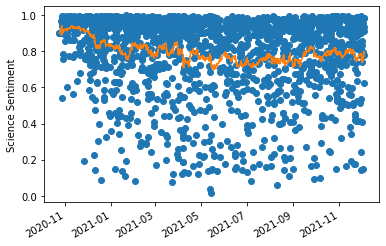

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fdates = []
dateformat = '%Y-%m-%d %H:%M:%S'
for dt in user_df['created_at']:
    fdates.append(datetime.strptime(dt,dateformat))
datesfinal = mdates.date2num(fdates)

user_df['SMA'] = user_df.sci_score.rolling(((round(.03*len(user_df.index)))),min_periods=1).mean()

plt.plot_date(datesfinal,user_df['sci_score'])
plt.plot_date(datesfinal,user_df['SMA'],linestyle='solid',marker=",")
plt.xlabel
plt.gcf().autofmt_xdate()
plt.ylabel('Science Sentiment')
plt.show(block=True)
